In [1]:
#ignore warning
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")
    
import pandas as pd
import statistics
import plotly.express as px
import numpy as np
import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import seaborn
from  matplotlib import pyplot
import matplotlib.image as mpimg

from sklearn import svm,tree, neighbors,linear_model, preprocessing
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, accuracy_score, confusion_matrix, classification_report, roc_curve, auc

In [2]:
#load in raw data
raw_data = pd.read_csv("ds_challenge_v2_1_data.csv")
print(raw_data.shape)
print(raw_data.iloc[:5])

(54681, 11)
   id city_name    signup_os signup_channel signup_date bgc_date  \
0   1    Strark      ios web           Paid      1/2/16      NaN   
1   2    Strark      windows           Paid     1/21/16      NaN   
2   3   Wrouver      windows        Organic     1/11/16  1/11/16   
3   4    Berton  android web       Referral     1/29/16   2/3/16   
4   5    Strark  android web       Referral     1/10/16  1/25/16   

  vehicle_added_date vehicle_make vehicle_model  vehicle_year  \
0                NaN          NaN           NaN           NaN   
1                NaN          NaN           NaN           NaN   
2                NaN          NaN           NaN           NaN   
3             2/3/16       Toyota       Corolla        2016.0   
4            1/26/16      Hyundai        Sonata        2016.0   

  first_completed_date  
0                  NaN  
1                  NaN  
2                  NaN  
3               2/3/16  
4                  NaN  


In [3]:
raw_data.dtypes

id                        int64
city_name                object
signup_os                object
signup_channel           object
signup_date              object
bgc_date                 object
vehicle_added_date       object
vehicle_make             object
vehicle_model            object
vehicle_year            float64
first_completed_date     object
dtype: object

In [4]:
raw_data['signup_date'] = pd.to_datetime(raw_data['signup_date'], format='%m/%d/%y')
raw_data['bgc_date'] = pd.to_datetime(raw_data['bgc_date'], format='%m/%d/%y')
raw_data['vehicle_added_date'] = pd.to_datetime(raw_data['vehicle_added_date'], format='%m/%d/%y')
raw_data['first_completed_date'] = pd.to_datetime(raw_data['first_completed_date'], format='%m/%d/%y')

signup_os               12.540005
bgc_date                39.840164
vehicle_added_date      75.980688
vehicle_make            75.817926
vehicle_model           75.817926
vehicle_year            75.817926
first_completed_date    88.776723
dtype: float64


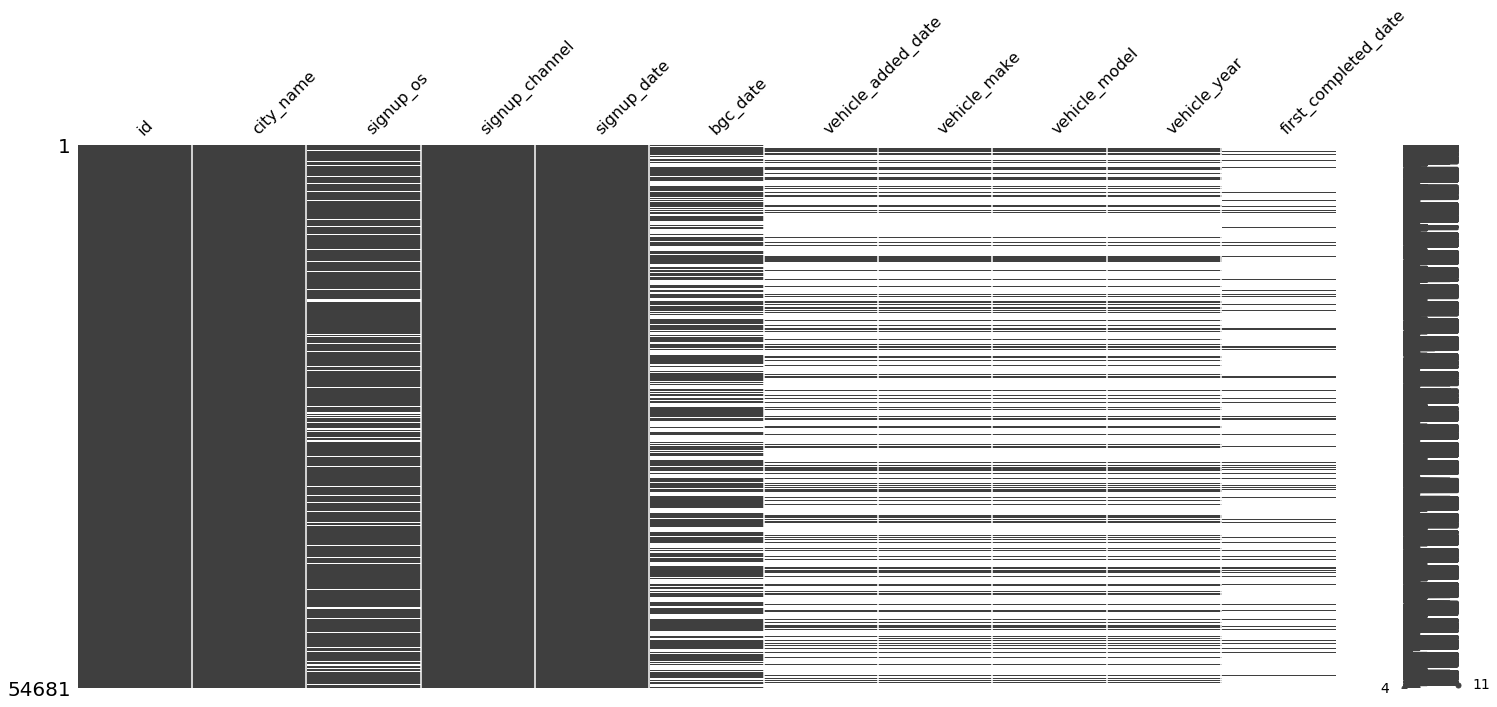

In [5]:
#missing values percentage
raw_data_nas = len(raw_data)
na_data = raw_data.loc[:, (raw_data.isnull().sum() >  0.0001 * raw_data_nas)]
print(na_data.isnull().sum()/raw_data_nas*100)
msno.matrix(raw_data) 

In [6]:
#values missing at random 
rand_miss = raw_data[raw_data.signup_date.notnull() & raw_data.first_completed_date.notnull()]
rand_miss2= rand_miss[rand_miss.bgc_date.isnull()]
print(len(rand_miss2)," of registers whose bgc_date is missing at random")

platform = rand_miss[rand_miss.signup_os.isnull()]
print(len(platform)," of registers whose registration platform is missing at random")

rand_miss3= rand_miss2[rand_miss2.vehicle_added_date.isnull()]
print(len(rand_miss3)," of registers whose vehicle_added_date is missing at random")

no_sign = raw_data[raw_data.signup_date.isnull() & raw_data.bgc_date.isnull() & raw_data.vehicle_added_date.isnull() & raw_data.first_completed_date.isnull()]
s0 = len(no_sign)
p0 = round(len(no_sign)/len(raw_data.drop_duplicates()),2)*100
print(s0," of registers who didn't signed up and is", p0, "percent of all registers.")

0  of registers whose bgc_date is missing at random
148  of registers whose registration platform is missing at random
0  of registers whose vehicle_added_date is missing at random
0  of registers who didn't signed up and is 0.0 percent of all registers.


In [7]:
#### fill missing not at random
#impute 148 signup missing values with 'not_known' platform
raw_data['signup_os'] = raw_data['signup_os'].fillna('not_known')
raw_data['signup_channel'] = raw_data['signup_channel'].fillna('not_known')
raw_data['city_name'] = raw_data['city_name'].fillna('not_known')
raw_data['vehicle_make'] = raw_data['vehicle_make'].fillna('not_known')
raw_data['vehicle_model'] = raw_data['vehicle_model'].fillna('not_known')

In [8]:
#### date values missing not at random
stage1 = raw_data[raw_data.bgc_date.isnull() & raw_data.vehicle_added_date.isnull() & raw_data.first_completed_date.isnull()]
s1 = len(stage1)-s0
p1 = round(len(stage1)/len(raw_data.drop_duplicates()),2)*100 - p0
print(s1," of registers who didn't have background check and is", p1,"percent of all registers.")

stage2 = raw_data[raw_data.vehicle_added_date.isnull() & raw_data.first_completed_date.isnull()]
s2 = len(stage2) - s0 - s1
p2 = round(len(stage2)/len(raw_data.drop_duplicates()),2)*100 - p0 - p1
print(s2," additional registers who didn't move to add vehicle step and increase", p2,"percent of all registers.")

stage3 = raw_data[raw_data.first_completed_date.isnull()]
s3 = len(stage3) - s0 - s1 - s2
p3 = round(len(stage3)/len(raw_data.drop_duplicates()),2)*100 - p0 - p1 - p2
print(s3," additional registers who didn't have first ride and is", p3,"percent of all registers.")

21530  of registers who didn't have background check and is 39.0 percent of all registers.
19752  additional registers who didn't move to add vehicle step and increase 36.0 percent of all registers.
7262  additional registers who didn't have first ride and is 14.0 percent of all registers.


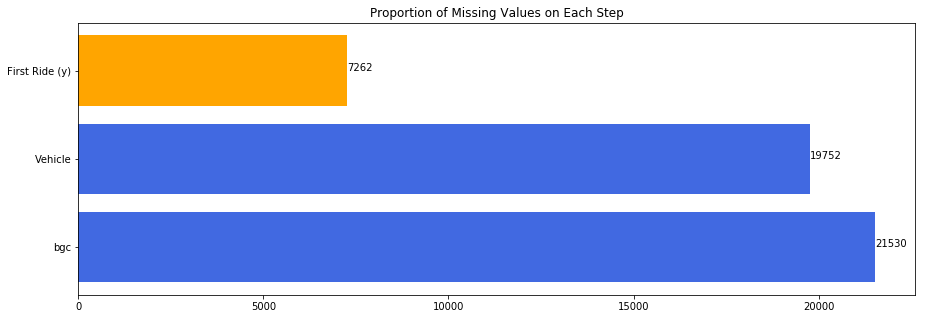

In [9]:
#check balance of missing value
plt.figure(figsize=(15,5))
x = ['bgc', 'Vehicle', 'First Ride (y)']
y = [s1, s2, s3]
colors = ['royalblue','royalblue','orange']
barlist = plt.barh(x, y, color = colors)
plt.title('Proportion of Missing Values on Each Step')
for index, value in enumerate(y):
    plt.text(value, index, str(value))

plt.show()
#first ride is the target variable for predict
#The other two variables have equally the same proportion

In [10]:
#add binary features to each stage 
raw_data['bgc_binary'] = raw_data['bgc_date'].notnull().astype(int)
raw_data['vehicle_inspection_binary'] = raw_data['vehicle_added_date'].notnull().astype(int)
raw_data['first_completed_date_binary'] = raw_data['first_completed_date'].notnull().astype(int)
raw_data['vehicle_make_binary'] = raw_data['vehicle_make'].notnull().astype(int)
raw_data['signup_os_binary'] = raw_data['signup_os'].notnull().astype(int)
raw_data['vehicle_year_binary'] = raw_data['vehicle_year'].notnull().astype(int)

In [11]:
#add time series features
raw_data['signup_to_bgc'] = (raw_data['bgc_date'] - raw_data['signup_date'])/ np.timedelta64(1, 'D')
raw_data['bgc_to_vehicle_add'] = (raw_data['vehicle_added_date'] - raw_data['bgc_date'])/ np.timedelta64(1, 'D')
raw_data['vehicle_to_ride'] = (raw_data['first_completed_date'] - raw_data['vehicle_added_date'])/ np.timedelta64(1, 'D')

In [12]:
#add weekday features
raw_data['signup_weekday'] = raw_data['bgc_date'].apply(lambda x: x.weekday())
raw_data['signup_weekday_binary'] = raw_data['bgc_date'].apply(lambda x: x.weekday() <= 4)

In [13]:
#center year value
raw_data['vehicle_year']=raw_data['vehicle_year']-2000

In [14]:
#prevent negative values
minVal = 0
raw_data['bgc_to_vehicle_add']=raw_data['bgc_to_vehicle_add'].where(raw_data['bgc_to_vehicle_add'] >= minVal, minVal)  
raw_data['vehicle_to_ride']=raw_data['vehicle_to_ride'].where(raw_data['vehicle_to_ride'] >= minVal, minVal) 
raw_data['vehicle_year']=raw_data['vehicle_year'].where(raw_data['vehicle_year'] >= minVal, minVal) 
raw_data.describe()

,id,vehicle_year,bgc_binary,vehicle_inspection_binary,first_completed_date_binary,vehicle_make_binary,signup_os_binary,vehicle_year_binary,signup_to_bgc,bgc_to_vehicle_add,vehicle_to_ride,signup_weekday
count,54681.000000,54681.000000,54681.000000,54681.000000,54681.000000,54681.0,54681.0,54681.000000,32896.000000,54681.000000,54681.000000,32896.000000
mean,27341.000000,2.703206,0.601598,0.240193,0.112233,1.0,1.0,0.241821,10.046541,1.710466,0.638010,3.006323
std,15785.189372,5.198099,0.489573,0.427205,0.315656,0.0,0.0,0.428190,10.519617,5.400690,2.650719,1.983874
min,1.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
25%,13671.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,2.000000,0.000000,0.000000,1.000000
50%,27341.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,0.000000,6.000000,0.000000,0.000000,3.000000
75%,41011.000000,0.000000,1.000000,0.000000,0.000000,1.0,1.0,0.000000,15.000000,0.000000,0.000000,5.000000
max,54681.000000,17.000000,1.000000,1.000000,1.000000,1.0,1.0,1.000000,69.000000,55.000000,30.000000,6.000000


In [15]:
#missing values percentage
raw_data_nas = len(raw_data)
na_data = raw_data.loc[:, (raw_data.isnull().sum() >  0.0001 * raw_data_nas)]
print(na_data.isnull().sum()/raw_data_nas*100)

bgc_date                39.840164
vehicle_added_date      75.980688
first_completed_date    88.776723
signup_to_bgc           39.840164
signup_weekday          39.840164
dtype: float64


In [16]:
#fill out missing value in bgc_date, vehicle_added_date, first_completed_date, signup_to_bgc, signup_weekday
#along with binary factor to tell if that value is null or has actual numeric meaning
clean_data = raw_data
clean_data = raw_data.fillna(0)

Series([], dtype: float64)


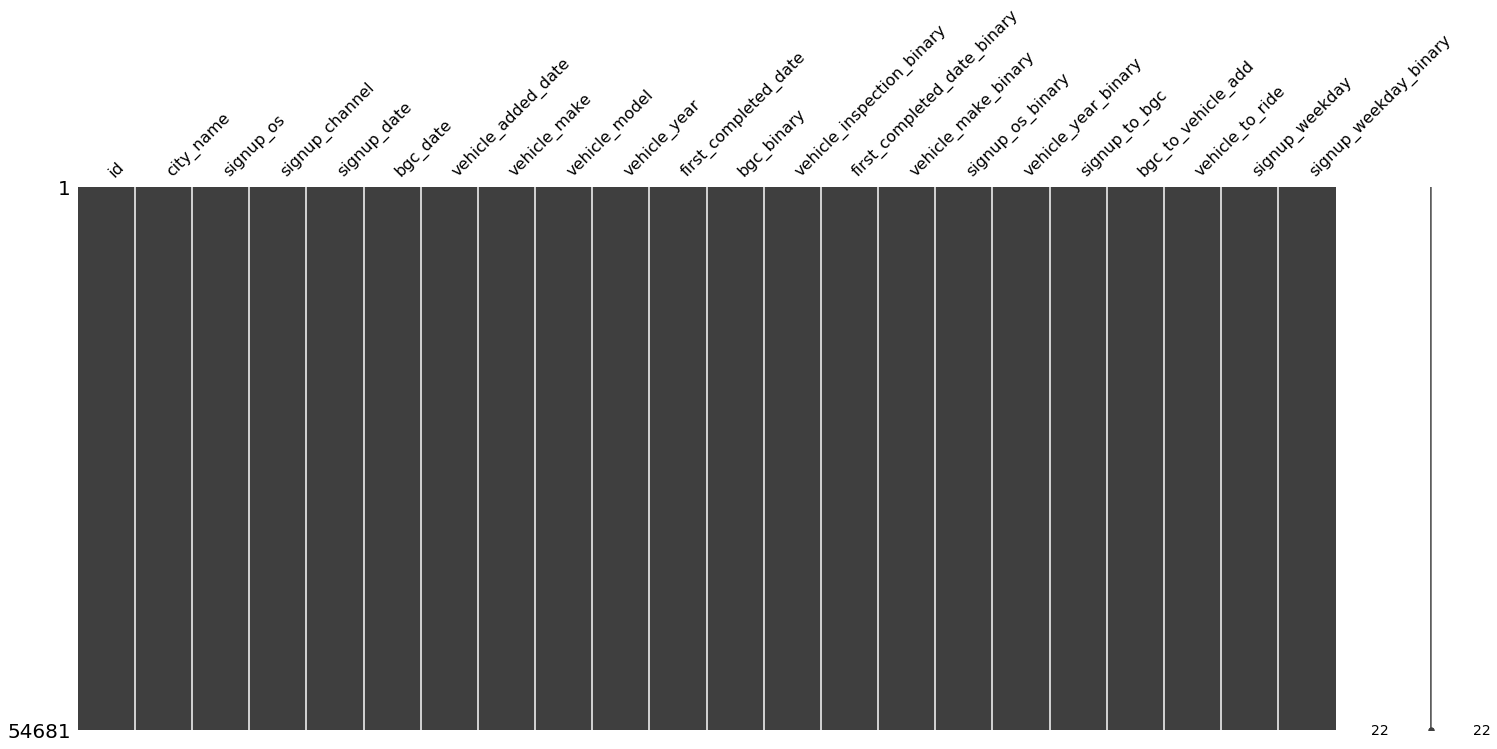

In [17]:
#missing values percentage
raw_data_nas = len(clean_data)
na_data = clean_data.loc[:, (clean_data.isnull().sum() >  0.0001 * raw_data_nas)]
print(na_data.isnull().sum()/raw_data_nas*100)
msno.matrix(clean_data) 

In [18]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
clean_data.city_name = le.fit_transform(clean_data.city_name)
clean_data.signup_os = le.fit_transform(clean_data.signup_os)
clean_data.signup_channel = le.fit_transform(clean_data.signup_channel)
clean_data.vehicle_make = le.fit_transform(clean_data.vehicle_make)
clean_data.vehicle_model = le.fit_transform(clean_data.vehicle_model)

In [19]:
X=clean_data[['city_name','signup_os', 'signup_channel', 'vehicle_make',
           'vehicle_model','vehicle_year', 'bgc_binary',
       'vehicle_inspection_binary', 
       'vehicle_make_binary', 'signup_os_binary', 'signup_to_bgc',
       'bgc_to_vehicle_add', 'vehicle_to_ride', 'signup_weekday',
       'signup_weekday_binary']]
y=clean_data[['first_completed_date_binary']]

In [20]:
raw_data_nas = len(X)
na_data = X.loc[:, (X.isnull().sum() >  0.0001 * raw_data_nas)]
print(na_data.isnull().sum()/raw_data_nas*100)

Series([], dtype: float64)


In [21]:
X.describe()

,city_name,signup_os,signup_channel,vehicle_make,vehicle_model,vehicle_year,bgc_binary,vehicle_inspection_binary,vehicle_make_binary,signup_os_binary,signup_to_bgc,bgc_to_vehicle_add,vehicle_to_ride,signup_weekday
count,54681.000000,54681.000000,54681.000000,54681.000000,54681.000000,54681.000000,54681.000000,54681.000000,54681.0,54681.0,54681.000000,54681.000000,54681.000000,54681.000000
mean,0.723670,1.779832,1.071122,41.051974,314.008943,2.703206,0.601598,0.240193,1.0,1.0,6.043982,1.710466,0.638010,1.808599
std,0.618962,1.690102,0.746443,10.936037,102.134715,5.198099,0.489573,0.427205,0.0,0.0,9.527083,5.400690,2.650719,2.129309
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000,46.000000,364.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000,0.000000,0.000000,0.000000
50%,1.000000,1.000000,1.000000,46.000000,364.000000,0.000000,1.000000,0.000000,1.0,1.0,1.000000,0.000000,0.000000,1.000000
75%,1.000000,3.000000,2.000000,46.000000,364.000000,0.000000,1.000000,0.000000,1.0,1.0,9.000000,0.000000,0.000000,4.000000
max,2.000000,5.000000,2.000000,46.000000,368.000000,17.000000,1.000000,1.000000,1.0,1.0,69.000000,55.000000,30.000000,6.000000


In [22]:
X_train, X_test, y_train, y_test = train_test_split(
    X, np.ravel(y), train_size=0.8)
k_fold = StratifiedKFold(n_splits=5)
clf_log = linear_model.LogisticRegression(solver='liblinear')
param_range = [0.01,0.1, 1, 10, 100]
params= {'C': param_range, 'penalty': ['l1','l2']}
scoring_fnc = make_scorer(accuracy_score)
grid = GridSearchCV(clf_log, param_grid=params,scoring=scoring_fnc,cv=k_fold)
grid = grid.fit(X_train, y_train)
clf_log = grid.best_estimator_

print('best score: %f'%grid.best_score_)
print('best parameters:')
for key in params.keys():
    print('%s: %s'%(key, clf_log.get_params()[key]))
print('test score: %f'%clf_log.score(X_test, y_test))

best score: 0.980660
best parameters:
C: 1
penalty: l1
test score: 0.982171


************Logistic Regression Performance************
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      9744
           1       1.00      0.84      0.91      1193

    accuracy                           0.98     10937
   macro avg       0.99      0.92      0.95     10937
weighted avg       0.98      0.98      0.98     10937



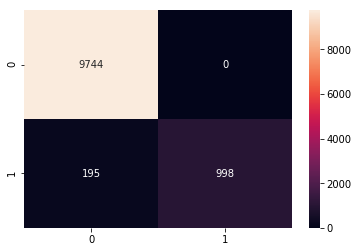

In [23]:
print('************Logistic Regression Performance************')
cm = confusion_matrix(y_test,clf_log.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

print(classification_report(y_test,clf_log.predict(X_test)))

****************Logistic Regression****************


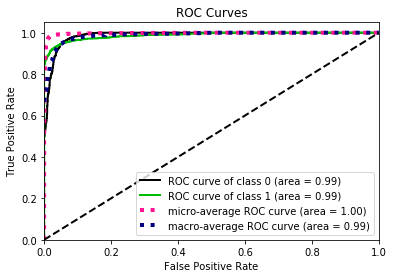

In [24]:
print('****************Logistic Regression****************')
y_probas_log = clf_log.predict_proba(X_test)
skplt.metrics.plot_roc(y_test, y_probas_log)
plt.show()